## 0. Setting up the Environment


In [8]:
## impoort labaries 
import os 
import cv2
import mat73
import time
import keras
import pandas as pd
import numpy as np 
import seaborn as sns
import skimage
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage.transform import resize
from keras.models import Sequential
from tensorflow.keras import optimizers
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D

## 1. Data Importing 

In [9]:
SIZE_X = 128
SIZE_Y = 128
SIZE_Z = 1
CLASS_NUM = 6

aug_train_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_train_DF_{}.pkl".format(SIZE_X))
aug_val_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_val_DF_{}.pkl".format(SIZE_X))
 = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_test_DF_{}.pkl".format(SIZE_X))

In [10]:
## Combain the df with the Pitutary & Meningioma types with the dataframe of the Glioma grades (I, II,, IV).
pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).sample(5)

,PID,Label,Image,File
12327,HF1280,Glioma III,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
13657,HF1397,Glioma VI,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
10412,Heatly_dataset_#998,No tumor,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",no243.jpg
14348,HF1538,Glioma VI,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
119,HF1185,Glioma III,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...


In [11]:
pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16980 entries, 0 to 16979
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PID     16980 non-null  object
 1   Label   16980 non-null  object
 2   Image   16980 non-null  object
 3   File    16980 non-null  object
dtypes: object(4)
memory usage: 530.8+ KB


C:\Users\Ma7moud\anaconda3\envs\T-UNet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


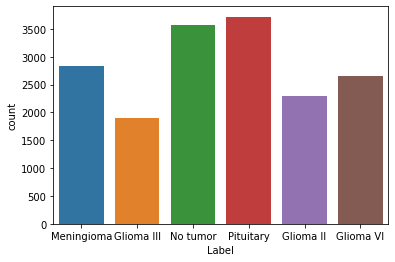

In [12]:
sns.countplot(pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).Label)
plt.show()

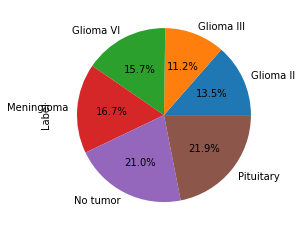

In [13]:
data = pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

## 2. Data-Preprocessing 

### 2.1 Image Resizing 


### 2.2 Data Augmentation

### 2.3 Grayscale to RGB

In [14]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')[:, :, SIZE_Z]

In [15]:
aug_train_DF["Image"] = aug_train_DF["Image"].apply(normalize)
aug_val_DF["Image"] = aug_val_DF["Image"].apply(normalize)
aug_test_DF["Image"] = aug_test_DF["Image"].apply(normalize)

### 2.4 Splitting Data into Train, Test, and Validation Sets

In [16]:
y_train = aug_train_DF["Label"]
X_train = aug_train_DF['Image'].tolist()
X_train = np.array(X_train).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)


y_val = aug_val_DF["Label"]
X_val = aug_val_DF['Image'].tolist()
X_val = np.array(X_val).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)

y_test = aug_test_DF["Label"]
X_test = aug_test_DF['Image'].tolist()
X_test = np.array(X_test).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)


In [17]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (13960, 128, 128, 1) | y_train shape: (13960,)
X_val shape  : (1112, 128, 128, 1)  | y_test shape :  (1112,)
X_test shape : (1908, 128, 128, 1)  | y_test shape :  (1908,)


### 2.5 One-Hot Encode the labels 

In [18]:
# saving a copy of the testing labels before one hot encoding
y_test_eval = y_test
# one hot endcoding the labels 
y_train = pd.get_dummies(y_train)
y_test  = pd.get_dummies(y_test)
y_val   = pd.get_dummies(y_val)

In [19]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_test shape :",X_test.shape," | y_test shape: ", y_test.shape)
print("X_val shape  :",X_val.shape," | y_val shape : ", y_val.shape)
print("\nTotal number: {}".format(len(aug_train_DF)+len(aug_val_DF)+len(aug_test_DF)))

X_train shape: (13960, 128, 128, 1) | y_train shape: (13960, 6)
X_test shape : (1908, 128, 128, 1)  | y_test shape:  (1908, 6)
X_val shape  : (1112, 128, 128, 1)  | y_val shape :  (1112, 6)

Total number: 16980


In [20]:
y_test

,Glioma II,Glioma III,Glioma VI,Meningioma,No tumor,Pituitary
0,0,0,0,1,0,0
1,1,0,0,0,0,0
2,0,0,0,1,0,0
3,0,0,0,0,0,1
4,0,0,0,1,0,0
...,...,...,...,...,...,...
1903,0,0,0,1,0,0
1904,0,0,0,0,0,1
1905,0,0,1,0,0,0
1906,0,0,0,0,0,1


### 2.6 Image Normalizatoin

In [21]:
X_train = X_train / 255
X_val   = X_val / 255
X_test  = X_test / 255

In [49]:
## This Dictionary is used to decode the model's predicted values.  
decode_dict = {0 : "Glioma II", 1 : "Glioma III", 2 : "Glioma VI", 3: "Meningioma", 4: "No tumor", 5: "Pituitary"}

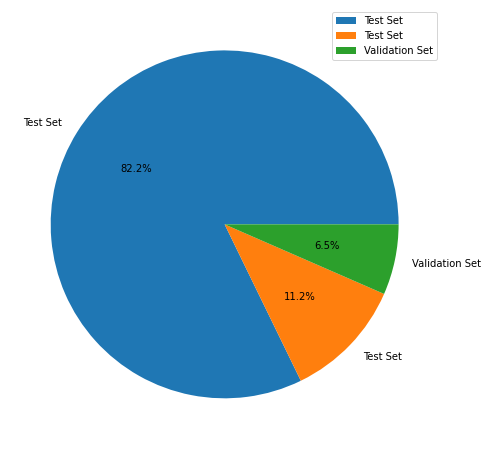

In [23]:
import matplotlib.pyplot as plt
import numpy as np
##  Creating a Pie chart illustrating the percentage of the train, validation, test sets.
Data = np.array([len(y_train), len(y_test), len(y_val)])
mylabels = ["Test Set", "Test Set", "Validation Set"]
plt.figure(figsize=(13, 8))
plt.pie(Data, labels = mylabels, autopct="%.1f%%", )
plt.legend()
plt.show() 

## 3. Models Creation


In [24]:
m1 = Sequential()

m1.add(Convolution2D( 32, (3,3), activation ='relu', input_shape = (SIZE_X, SIZE_Y, SIZE_Z))) 
m1.add(MaxPooling2D(pool_size=2))
m1.add(Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'))
m1.add(MaxPooling2D(pool_size=2))
m1.add(Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'))
m1.add(MaxPooling2D(pool_size=2))
m1.add(Dropout(0.50))
m1.add(Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'))
m1.add(MaxPooling2D(pool_size=2))
m1.add(Dropout(0.50))
m1.add(Flatten()) 
m1.add(Dense(units = 128, activation = 'relu'))
m1.add(Dense(units = 32, activation = 'relu'))
m1.add(Dense(units = CLASS_NUM, activation = 'softmax'))

m1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### 4. Model Training


In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 23 )

m1.fit(X_train,y_train,epochs=150,batch_size=16, validation_data=(X_val,y_val), callbacks = [early_stop], verbose=1)

Epoch 1/150
873/873 [==============================] - 11s 8ms/step - loss: 0.8545 - accuracy: 0.6561 - val_loss: 0.5422 - val_accuracy: 0.7914
Epoch 2/150
873/873 [==============================] - 7s 8ms/step - loss: 0.4528 - accuracy: 0.8160 - val_loss: 0.3640 - val_accuracy: 0.8498
Epoch 3/150
873/873 [==============================] - 7s 8ms/step - loss: 0.3459 - accuracy: 0.8595 - val_loss: 0.2841 - val_accuracy: 0.8804
Epoch 4/150
873/873 [==============================] - 7s 8ms/step - loss: 0.2796 - accuracy: 0.8879 - val_loss: 0.2982 - val_accuracy: 0.8669
Epoch 5/150
873/873 [==============================] - 7s 8ms/step - loss: 0.2421 - accuracy: 0.9047 - val_loss: 0.2132 - val_accuracy: 0.9110
Epoch 6/150
873/873 [==============================] - 7s 8ms/step - loss: 0.2054 - accuracy: 0.9203 - val_loss: 0.2096 - val_accuracy: 0.9227
Epoch 7/150
873/873 [==============================] - 7s 8ms/step - loss: 0.1845 - accuracy: 0.9289 - val_loss: 0.2476 - val_accuracy: 0.910

Epoch 58/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0366 - accuracy: 0.9891 - val_loss: 0.3080 - val_accuracy: 0.9371
Epoch 59/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0437 - accuracy: 0.9872 - val_loss: 0.4119 - val_accuracy: 0.9326
Epoch 60/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0454 - accuracy: 0.9869 - val_loss: 0.3160 - val_accuracy: 0.9388
Epoch 61/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0429 - accuracy: 0.9872 - val_loss: 0.3066 - val_accuracy: 0.9317
Epoch 62/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0350 - accuracy: 0.9889 - val_loss: 0.3645 - val_accuracy: 0.9164
Epoch 63/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0449 - accuracy: 0.9860 - val_loss: 0.2585 - val_accuracy: 0.9344
Epoch 64/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0325 - accuracy: 0.9902 - val_loss: 0.2544 - val_accuracy:

Epoch 115/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0381 - accuracy: 0.9913 - val_loss: 0.3087 - val_accuracy: 0.9469
Epoch 116/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0251 - accuracy: 0.9922 - val_loss: 0.3411 - val_accuracy: 0.9496
Epoch 117/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0261 - accuracy: 0.9928 - val_loss: 0.4056 - val_accuracy: 0.9379
Epoch 118/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0269 - accuracy: 0.9919 - val_loss: 0.3472 - val_accuracy: 0.9424
Epoch 119/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0410 - accuracy: 0.9903 - val_loss: 0.3406 - val_accuracy: 0.9415
Epoch 120/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.3230 - val_accuracy: 0.9532
Epoch 121/150
873/873 [==============================] - 7s 8ms/step - loss: 0.0360 - accuracy: 0.9918 - val_loss: 0.3665 - val_ac

In [26]:
# Get training history
metrics = pd.DataFrame(m1.history.history)

In [27]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [28]:
print(results)

./experiments/exp#4\results


In [29]:
# Save The Trained model along with it training history   
Accuracy = m1.evaluate(X_test, y_test)[-1]
name = str(round(Accuracy, 4))

metrics.to_pickle(os.path.join(results, name+'.pkl'))
m1.save(os.path.join(weights, name + '.h5'))

60/60 [==============================] - 1s 6ms/step - loss: 0.2034 - accuracy: 0.9544


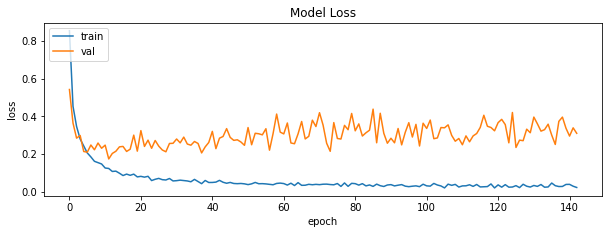

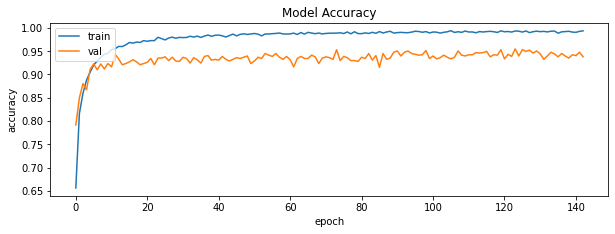

In [45]:
## Dispaly the plot of 
rows = 2
columns = 1
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.show()

  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 2)
plt.plot(metrics['accuracy'])
plt.plot(metrics['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'acc_epoch.png'))
plt.show()



In [50]:
## Get the 
predict_x = m1.predict(X_test) 
predictions = np.argmax(predict_x,axis=1) 

In [51]:
# Decode the Model's predections  (from [0,1,0,2..] to ['Glioma','Meningioma'...]) of the Test set using the the dictionary 'decode_dict' 
predictions = np.vectorize(decode_dict.get)(predictions)

In [52]:
print(classification_report(y_test_eval, predictions))

              precision    recall  f1-score   support

   Glioma II       0.75      0.96      0.84       112
  Glioma III       0.93      0.96      0.94       188
   Glioma VI       0.98      0.85      0.91       360
  Meningioma       0.99      0.96      0.97       432
    No tumor       0.97      1.00      0.99       204
   Pituitary       0.97      1.00      0.98       612

    accuracy                           0.95      1908
   macro avg       0.93      0.95      0.94      1908
weighted avg       0.96      0.95      0.95      1908



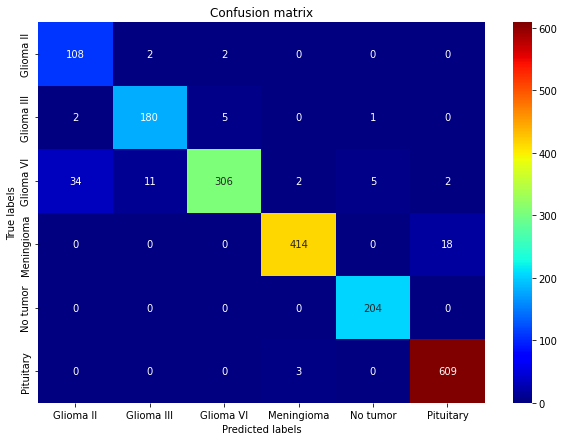

In [61]:
labels = sorted(aug_test_DF.Label.unique())

cm = pd.DataFrame(confusion_matrix(y_test_eval, predictions), index=labels, columns=labels)
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, cmap="jet",fmt = 'd')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(os.path.join(results, 'confusion_matrix.png'))
plt.show()

In [54]:
sorted(aug_test_DF.Label.unique())

['Glioma II', 'Glioma III', 'Glioma VI', 'Meningioma', 'No tumor', 'Pituitary']

In [73]:
len(aug_test_DF[aug_test_DF.Label == "No tumor"])

204